# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [1]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow

tensorflow 1.14.0 requires google-pasta>=0.1.6, which is not installed.
distributed 1.21.8 requires msgpack, which is not installed.
tensorboard 1.14.0 has requirement setuptools>=41.0.0, but you'll have setuptools 39.1.0 which is incompatible.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE


plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [3]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [4]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [5]:
# Loading the dataset
# eg.
dirpath = './dataset/IMFDB/'
dirpath1='./dataset/IIIT-CFW/'
dirpath2='./dataset/Yale_face_database'
X,y = load_data(dirpath)
X1,y1 = load_data(dirpath1)
X2,y2 = load_data(dirpath2)
global N,H,W,N1,H1,W1,N2,H2,W2
N,H,W = X.shape[0:3]
N1,H1,W1 = X1.shape[0:3]
N2,H2,W2 = X2.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
C1 = 1 if opt['is_grayscale'] else X1.shape[3]
C2 = 1 if opt['is_grayscale'] else X2.shape[3]

Dataset shape: (400, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


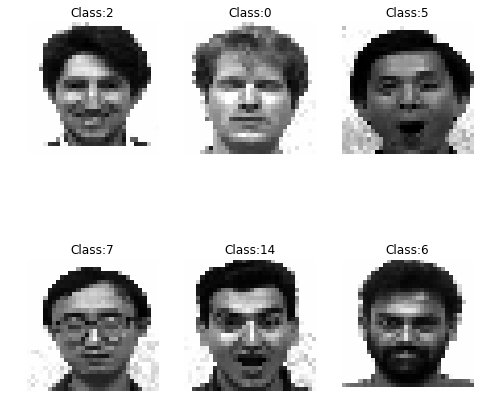

In [6]:
# disply_images(X[0],0)# Show sample images
ind = np.random.randint(0,y2.shape[0],6)
disply_images(X2[ind,...],y2[ind], row=2,col=3)

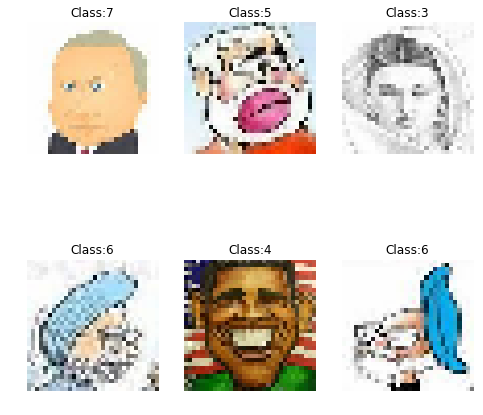

In [7]:
# Show sample images
ind = np.random.randint(0,y1.shape[0],6)
disply_images(X1[ind,...],y1[ind], row=2,col=3)

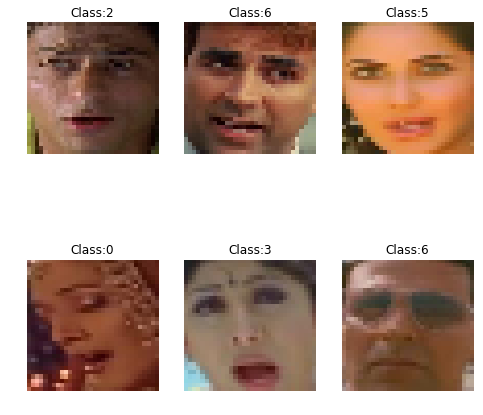

In [8]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [9]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

In [10]:
X1 = X1.reshape((N1,H1*W1*C1))

In [11]:
X2 = X2.reshape((N2,H2*W2*C2))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [12]:
def get_pca(X,k,data_set,give_inverse=0):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    if data_set==1:
        X = X.reshape((N,H*W*C))   
    if data_set==2:
        X = X.reshape((N1,H1*W1*C1))   
    if data_set==3:
        X = X.reshape((N2,H2*W2*C2))   
    
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    
    if give_inverse==1:
        return pca.inverse_transform(X_k)
    else:
#         print(X_k.shape)
        return X_k

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [13]:
def get_kernel_pca(X, k,data_set,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    if data_set==1:
        X = X.reshape((N,H*W*C))   
    if data_set==2:
        X = X.reshape((N1,H1*W1*C1))   
    if data_set==3:
        X = X.reshape((N2,H2*W2*C2))  
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    X_k = kpca.fit_transform(X)
    return X_k

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [14]:
def get_lda(X,y, k,data_set):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    if data_set==1:
        X = X.reshape((N,H*W*C))   
    if data_set==2:
        X = X.reshape((N1,H1*W1*C1))   
    if data_set==3:
        X = X.reshape((N2,H2*W2*C2)) 
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [15]:
def get_kernel_lda(X,y,k,data_set,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    if data_set==1:
        X = X.reshape((N,H*W*C))   
    if data_set==2:
        X = X1.reshape((N1,H1*W1*C1))   
    if data_set==3:
        X = X2.reshape((N2,H2*W2*C2)) 
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    return X_k

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [16]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features
# get_vgg_features(dirpath).shape

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [17]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

___________________________
1)Eigenfaces are an <b><i>orthogonal basis set</i> </b>(because covariance matrix is PSD) from which most of all faces can be constructed.They are basically eigen vectors of the image after smoothening or reshaping images  to a 2-D vector.
<br>

2)They are blurry depictions of faces that each highlight a certain type of feature. 
<br>

3)Eigenfaces are constructed by training on a set of real faces.
<br>

4)The goal is to create the minimum number of eigenfaces that can adequately represent the entire training set.It is a type of <b><i>Principal Component Analysis</i><b>




1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

Dataset shape: (400, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)
(400, 32, 32, 3)
Cumulative Variance choosed here  :  0.9601550671573126
Number of components to choose:  142


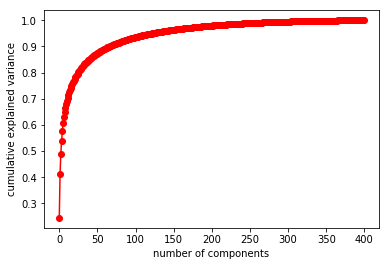

(672, 32, 32, 3)
Cumulative Variance choosed here  :  0.9601586908166865
Number of components to choose:  338


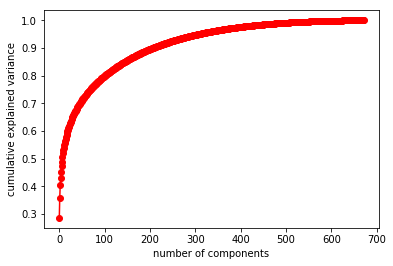

(165, 32, 32, 3)
Cumulative Variance choosed here  :  0.9601718076627038
Number of components to choose:  69


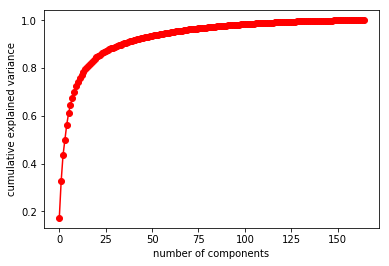

In [18]:
# PCA
def smooth_data(X,a,b,c,d):
    X = X.reshape((a,b*c*d))
    return X
def pca_components_to_select(X,a,b,c,d):
    X_sm=smooth_data(X,a,b,c,d)
    print(X.shape)
    cov= PCA().fit(X_sm)
    cum_var=np.cumsum(cov.explained_variance_ratio_)
    # print(cum_var)
    plt.plot(cum_var,c='r',marker='o')
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    l=cum_var[cum_var>=0.96]
    print("Cumulative Variance choosed here  : ",l[0])
    comp=list(cum_var).index(l[0])
    print("Number of components to choose: ",comp)
    plt.show()
    return comp

dirpath = './dataset/IMFDB/'
dirpath1='./dataset/IIIT-CFW/'
dirpath2='./dataset/Yale_face_database'
X,y = load_data(dirpath)
X1,y1 = load_data(dirpath1)
X2,y2 = load_data(dirpath2)
c_1=pca_components_to_select(X,N,H,W,C)
c_2=pca_components_to_select(X1,N1,H1,W1,C1)
c_3=pca_components_to_select(X2,N2,H2,W2,C2)

In [19]:
# Compute your features 
# eg.
# X_3D = get_kernel_lda(X,y,3)
X_3D_1 = get_pca(X,c_1,1,0)

X_3D_2 = get_pca(X1,c_2,2,0)

X_3D_3 = get_pca(X2,c_3,3,0)

print(X_3D_1.shape)
print(X_3D_2.shape)
print(X_3D_3.shape)

(400, 142)
(672, 338)
(165, 69)


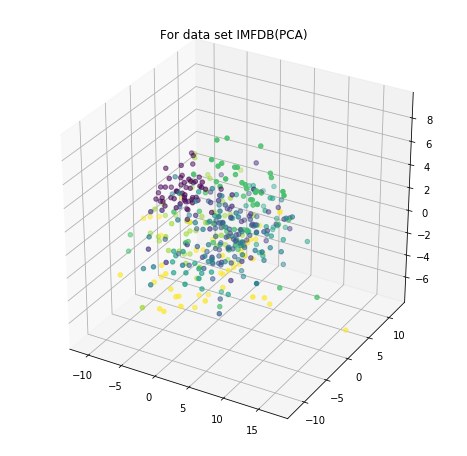

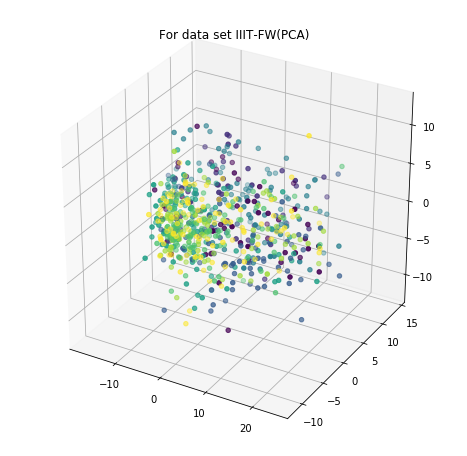

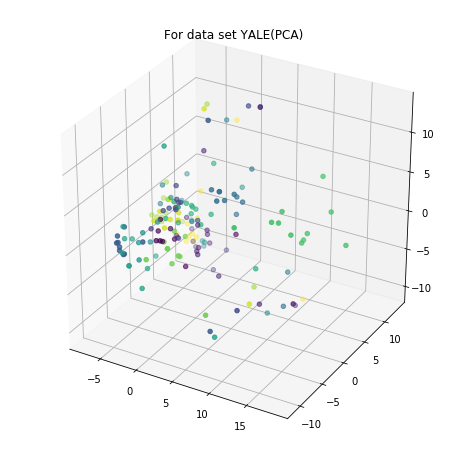

In [20]:
# Create a scatter plot  
# eg.

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D_1[:,0],X_3D_1[:,1],X_3D_1[:,2],c=y)
plt.title("For data set IMFDB(PCA)")
plt.show()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D_2[:,0],X_3D_2[:,1],X_3D_2[:,2],c=y1)
plt.title("For data set IIIT-FW(PCA)")

plt.show()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D_3[:,0],X_3D_3[:,1],X_3D_3[:,2],c=y2)
plt.title("For data set YALE(PCA)")
plt.show()

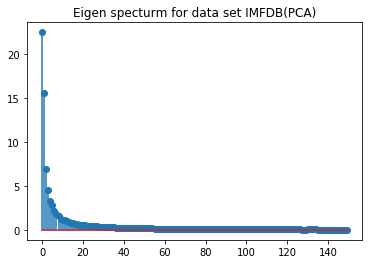

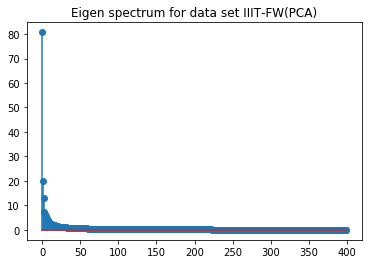

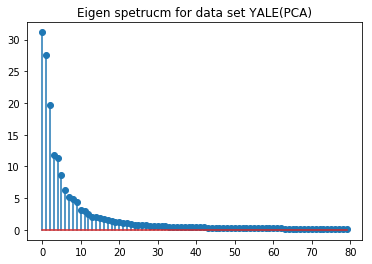

In [21]:
# Plot the eigen value spectrum 
from numpy import linalg
X=smooth_data(X,N,H,W,C)
a=np.transpose(X)
eigen_val,eigen_vec=linalg.eig(np.cov(a))
eigen_val=abs(eigen_val[0:150])
plt.stem(eigen_val)
plt.title("Eigen specturm for data set IMFDB(PCA)")

plt.show()

X1=smooth_data(X1,N1,H1,W1,C1)
a=np.transpose(X1)
eigen_val,eigen_vec=linalg.eig(np.cov(a))
eigen_val=abs(eigen_val[0:400])
plt.stem(eigen_val)
plt.title("Eigen spectrum for data set IIIT-FW(PCA)")
plt.show()

X2=smooth_data(X2,N2,H2,W2,C2)
a=np.transpose(X2)
eigen_val,eigen_vec=linalg.eig(np.cov(a))
eigen_val=abs(eigen_val[0:80])
plt.stem(eigen_val)
plt.title("Eigen spetrucm for data set YALE(PCA)")
plt.show()

1(c). Reconstruct  the  image  back for each case


In [22]:
def reconstruct_images(X,comp,path):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    
#     pass
    reconstruct_X = get_pca(X,comp,path,1)
    
    return reconstruct_X    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


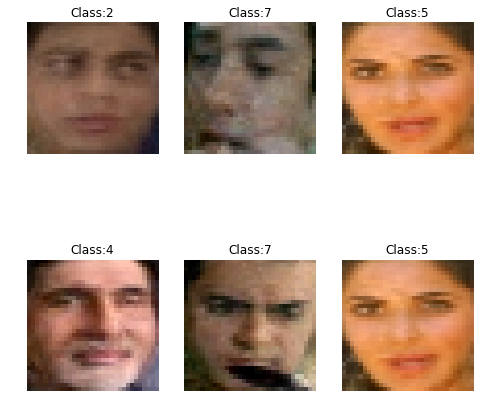

Reconstruction Error
0.034826348054786946


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


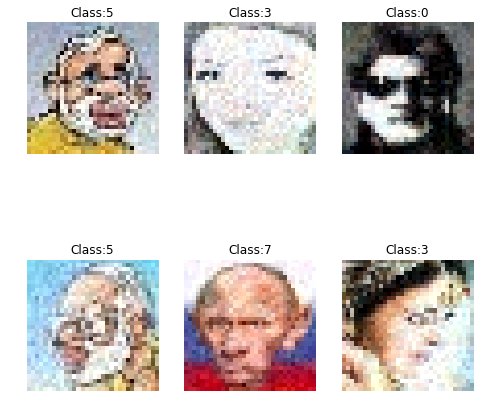

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstruction Error
0.06123870444454385


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


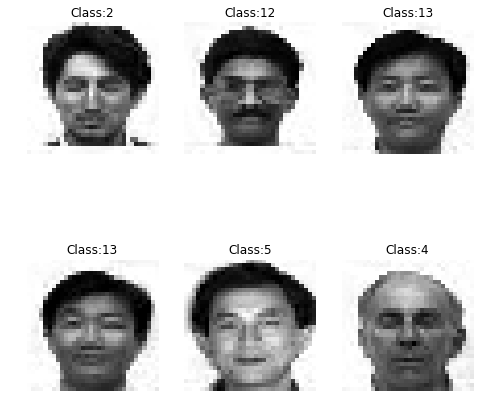

Reconstruction Error
0.04906626535303927


In [23]:
def reconstruction(X,y,co,path,a,b,c,d):
    X_reconstructed = reconstruct_images(X,co,path)
    # Display random images
    ind = np.random.randint(0,y.shape[0],6)
    disply_images(X_reconstructed.reshape(a,b,c,d)[ind,...],y[ind],row=2,col=3)
    # Show the reconstruction error
    print("Reconstruction Error")
    print(np.sqrt(np.mean((X - X_reconstructed)**2)))
    return X_reconstructed
re1=reconstruction(X,y,c_1,1,N,H,W,C)
re2=reconstruction(X1,y1,c_2,2,N1,H1,W1,C1)
re3=reconstruction(X2,y2,c_3,3,N2,H2,W2,C2)

1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

In [24]:
# code goes here
def Max_loss(X,y,re,ff):
    maxi=-1
    for i in range(ff):
        x=np.sqrt(np.mean((X[i] - re[i])**2))
        if(x>maxi):
            maxi=x
            ind=i
    print("Person id with highest loss","Loss=",maxi,"id=",ind,"class: ",y[ind])
    # np.mean(((X[0] - X_reconstructed[0])**2)).shape
    X_diff=X-re
    lo=[]
    po=len(np.unique(y))
    for i in range(po):
        lo.append(np.sqrt(np.mean(X_diff[y==i]**2)))
    s=np.argsort(lo)[::-1]
    print("Class:",s[0], "has most reconstruction loss"," Loss: ",lo[s[0]])
print("IMFDB")
Max_loss(X,y,re1,N)
print("IIITCFW")
Max_loss(X1,y1,re2,N1)
print("yale")
Max_loss(X2,y2,re3,N2)

IMFDB
Person id with highest loss Loss= 0.04495819688653201 id= 264 class:  0
Class: 2 has most reconstruction loss  Loss:  0.036191494818327355
IIITCFW
Person id with highest loss Loss= 0.07827367801645863 id= 264 class:  4
Class: 3 has most reconstruction loss  Loss:  0.0631809026472264
yale
Person id with highest loss Loss= 0.063431686704862 id= 120 class:  4
Class: 0 has most reconstruction loss  Loss:  0.053607519294180284


2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [25]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 

class Classifier():
    def __init__(self,start =1):
#         super.__init__()
         self.start = start
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
        """
        prediction=self.model.predict(X)
        class_labels_pred = np.argmax(prediction, axis=1)
        prediction=class_labels_pred
        return prediction
        
    def confusion_matrix(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        cm = confusion_matrix(pred, y)
        return cm
    def train(self,X_train,y_train,comp,out):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.model = Sequential()
        self.model.add(Dense(200, input_dim=comp,activation='relu'))
        self.model.add(Dense(200, activation='relu'))
        self.model.add(Dense(out, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        encoder = LabelEncoder()
        encoder.fit(y_train)
        encoded_Y = encoder.transform(y_train)
        y_tr=to_categorical(encoded_Y)        
        self.model.fit(X_train, y_tr,epochs=50,verbose=0)

    def validate(self,X_validate,y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        y_pred=self.model.predict(X_validate)
        class_labels_pred = np.argmax(y_pred, axis=1)
        val_acc = accuracy_score(y_validate,class_labels_pred,normalize = True)
        precision = precision_score(y_validate,class_labels_pred,average = 'macro')
        recall = recall_score(y_validate,class_labels_pred,average = 'macro')
        f1 = f1_score(y_validate,class_labels_pred,average = 'macro')
        
        # Create a confusion matrix
        
        
        # Calculate Validation accuracy 
    
        # Calculate precision and recall 
        
        # Calculate F1-score
        return val_acc,precision,recall,f1

In [26]:
# Create a train and validation split to train your classifier 
from sklearn.model_selection import train_test_split
def division_train_test(X,y,feature,comp,path):
#     global X_4D
    if path==1:
        dirpath = './dataset/IMFDB/'
    if path==2:
        dirpath='./dataset/IIIT-CFW/'
    if path==3:
        dirpath='./dataset/Yale_face_database/'      
    if(feature==1):       
        X_4D=get_pca(X,comp,path,0)
    if(feature==2):
        X_4D=get_kernel_pca(X,comp,path)
    if(feature==3):
        X_4D=get_lda(X,y,comp,path)
    if(feature==4):
        X_4D=get_kernel_lda(X,y,comp,path)
    if(feature==5):
        X_4D=get_vgg_features(dirpath)
    if(feature==6):
        X_4D=get_resnet_features(dirpath)
    X_train, X_test, y_train, y_test = train_test_split(X_4D, y, test_size=0.2)
#     print(X_train.shape, y_train.shape)
#     print(X_test.shape, y_test.shape)
    return X_train,X_test,y_train,y_test

In [27]:
from numpy import loadtxt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import initializers
from keras.utils import to_categorical 
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras import initializers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix as confMat
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score


C:\Users\charan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [28]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score
import pandas as pd
from  IPython.display import display
import warnings
comp1 = np.array([142,142,7,7,4096,2048])
comp2 = np.array([338,338,7,7,4096,2048])
comp3= np.array([69,69,7,7,4096,2048])
type_array = np.array([1,2,3,4,5,6])
feature_list = ['PCA+MLP','K_PCA+MLP','LDA+MLP','K_LDA+MLP','VGG+MLP','RESNET+MLP']
def faces_table(path):
    global comp1,comp2,comp3,type_array,feature_list
    acc = np.zeros(6)
    f1 = np.zeros(6)
    pre = np.zeros(6)
    rec = np.zeros(6)

    if path==1:
        X,y = load_data('./dataset/IMFDB/')
        comp=comp1
        out=8
    elif path==2:
        X,y = load_data('./dataset/IIIT-CFW/')
        comp=comp2
        out=8
    elif path==3:
        X,y = load_data('./dataset/Yale_face_database')
        comp=comp3
        out=15
    for i in range(6):
        X_train,X_test,y_train,y_test = division_train_test(X,y,feature=type_array[i],comp=comp[i],path=path)
        clf = Classifier(start=1)
        clf.train(X_train,y_train,comp[i],out)
        pred = clf.classify(X_test)
        acc[i],pre[i],rec[i],f1[i] = clf.validate(X_test,y_test)
    
    acc = 100*acc
    clf_err = 100 - acc
    best_model = np.argmax(acc)
    df = pd.DataFrame({
        'Method' : pd.Categorical(feature_list),
        'Reduced Space':comp,
        'Classification error':clf_err ,
        'Accuracy':acc ,
        'f1-score':f1,
        'precision':pre,
        'recall':rec })
    return df,best_model
# Print the table. (You can use Pandas)
best_models = np.zeros(3)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print("\nIMFDB")
    df1,best_models[0] = faces_table(path=1)
    display(df1)
    print("\nCFW")
    df2,best_models[1] = faces_table(path=2)
    display(df2)
    print("\nYale")
    df3,best_models[2] = faces_table(path=3)  
    display(df3)


IMFDB
Dataset shape: (400, 32, 32, 3)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



,Method,Reduced Space,Classification error,Accuracy,f1-score,precision,recall
0,PCA+MLP,142,13.75,86.25,0.858686,0.882080,0.856944
1,K_PCA+MLP,142,26.25,73.75,0.742443,0.741793,0.762847
2,LDA+MLP,7,2.50,97.50,0.976682,0.979021,0.976562
3,K_LDA+MLP,7,2.50,97.50,0.974687,0.981250,0.970779
4,VGG+MLP,4096,6.25,93.75,0.935303,0.942079,0.933093
5,RESNET+MLP,2048,5.00,95.00,0.936787,0.946726,0.934135



CFW
Dataset shape: (672, 32, 32, 3)


,Method,Reduced Space,Classification error,Accuracy,f1-score,precision,recall
0,PCA+MLP,338,45.185185,54.814815,0.540898,0.560086,0.547899
1,K_PCA+MLP,338,45.925926,54.074074,0.527487,0.549492,0.524451
2,LDA+MLP,7,2.962963,97.037037,0.967082,0.965635,0.970702
3,K_LDA+MLP,7,4.444444,95.555556,0.946659,0.956169,0.940152
4,VGG+MLP,4096,33.333333,66.666667,0.656626,0.658465,0.667660
5,RESNET+MLP,2048,5.185185,94.814815,0.937171,0.960556,0.924937



Yale
Dataset shape: (165, 32, 32, 3)


,Method,Reduced Space,Classification error,Accuracy,f1-score,precision,recall
0,PCA+MLP,69,12.121212,87.878788,0.875397,0.923333,0.883333
1,K_PCA+MLP,69,15.151515,84.848485,0.802041,0.832143,0.833333
2,LDA+MLP,7,3.030303,96.969697,0.976068,0.984615,0.974359
3,K_LDA+MLP,7,0.000000,100.000000,1.000000,1.000000,1.000000
4,VGG+MLP,4096,30.303030,69.696970,0.653651,0.688889,0.711111
5,RESNET+MLP,2048,6.060606,93.939394,0.888254,0.900000,0.894444


In [29]:
print(best_models)

[2. 2. 3.]


Dataset shape: (400, 32, 32, 3)

 LDA+MLP for IMFDB
[[11  0  0  0  0  0  0  0]
 [ 0  8  1  0  0  0  0  0]
 [ 0  0  8  0  0  0  0  0]
 [ 1  0  0  9  0  0  0  0]
 [ 0  0  0  0  9  0  0  0]
 [ 0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0 14]]


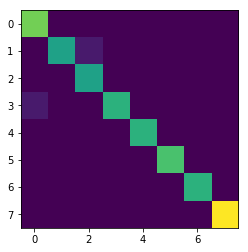

Dataset shape: (672, 32, 32, 3)

 LDA+MLP for CFW
[[10  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0]
 [ 0  0 17  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0]
 [ 0  0  0  0 19  0  0  0]
 [ 0  0  0  0  0 20  0  0]
 [ 0  0  0  1  0  0 21  0]
 [ 0  0  0  1  0  0  0 25]]


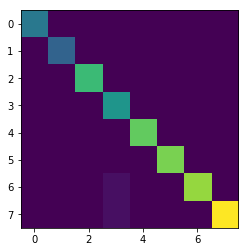

Dataset shape: (165, 32, 32, 3)

 K_LDA+MLP for Yale
[[5 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2]]


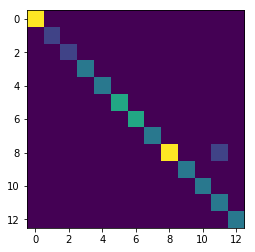

In [30]:
# For each dataset print the confusion matrix for the best model 
dir_list = ['./dataset/IMFDB/','./dataset/IIIT-CFW/','./dataset/Yale_face_database/']
datasets = ['IMFDB','CFW','Yale']
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(3):
        X,y = load_data(dir_list[i])
        j = best_models[i].astype('uint')
        if(i==0):
            comp=comp1
            out=8
        if(i==1):
            comp=comp2
            out=8
        if(i==2):
            comp=comp3
            out=15
        X_train,X_test,y_train,y_test = division_train_test(X,y,feature=type_array[j],comp=comp[j],path=i+1)
        clf = Classifier(start=1)
        clf.train(X_train,y_train,comp[j],out)
        pred = clf.classify(X_test)
        print("\n",feature_list[j],"for",datasets[i])
        print(clf.confusion_matrix(pred,y_test))
        plt.imshow(confusion_matrix(pred,y_test))
        plt.show()

3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

In [31]:
def Features_for_TSNE(feature,comp,path):
    if path==1:
        dirpath = './dataset/IMFDB/'
        X,y=load_data(dirpath)
    if path==2:
        dirpath='./dataset/IIIT-CFW/'
        X,y=load_data(dirpath)
    if path==3:
        dirpath='./dataset/Yale_face_database/'      
        X,y=load_data(dirpath)
    if(feature==1):       
        X_4D=get_pca(X,comp,path,0)
    if(feature==2):
        X_4D=get_kernel_pca(X,comp,path)
    if(feature==3):
        X_4D=get_lda(X,y,comp,path)
    if(feature==4):
        X_4D=get_kernel_lda(X,y,comp,path)
    if(feature==5):
        X_4D=get_vgg_features(dirpath)
    if(feature==6):
        X_4D=get_resnet_features(dirpath)
    return X_4D,y

In [32]:
def Features_for_COMBINED_DATASET_TSNE(X,y,feature,comp):
    N_n,H_n,W_n = X.shape[0:3]
    C_n = 1 if opt['is_grayscale'] else X.shape[3]
    X = X.reshape((N_n,H_n*W_n*C_n))
    if(feature==1):       
        pca = PCA(n_components=comp)
        X_4D = pca.fit_transform(X)
    if(feature==2):
        kpca = KernelPCA(n_components=comp,kernel='rbf',degree=3)
        X_4D = kpca.fit_transform(X)
    if(feature==4):
        kernel="rbf"
        degree=3
        if kernel == "poly":
            X_transformed = X**degree
        elif kernel == "rbf":
            var = np.var(X)
            X_transformed= np.exp(-X/(2*var))
        elif kernel == "sigmoid":
            X_transformed = np.tanh(X)
        else: 
            raise NotImplementedError("Kernel {} Not defined".format(kernel))
        klda = LDA(n_components=comp)
        X_4D = klda.fit_transform(X,y)
    if(feature==3):
        lda = LDA(n_components=comp)
        X_4D = lda.fit_transform(X,y)
#     if(feature==5):
#         X_4D=get_vgg_features(dirpath)
#     if(feature==6):
#         X_4D=get_resnet_features(dirpath)
    return X_4D,y

In [33]:
import matplotlib.patheffects as PathEffects
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
#     plt.xlim(-25, 25)
#     plt.ylim(-25, 25)
#     ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, 0:2], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc,txts

Dataset shape: (400, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)


C:\Users\charan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dataset shape: (400, 32, 32, 3)


C:\Users\charan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dataset shape: (400, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)


C:\Users\charan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dataset shape: (672, 32, 32, 3)


C:\Users\charan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dataset shape: (672, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


C:\Users\charan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dataset shape: (165, 32, 32, 3)


C:\Users\charan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dataset shape: (165, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


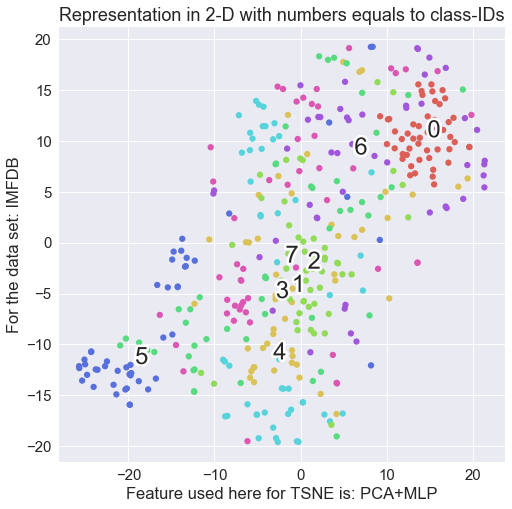

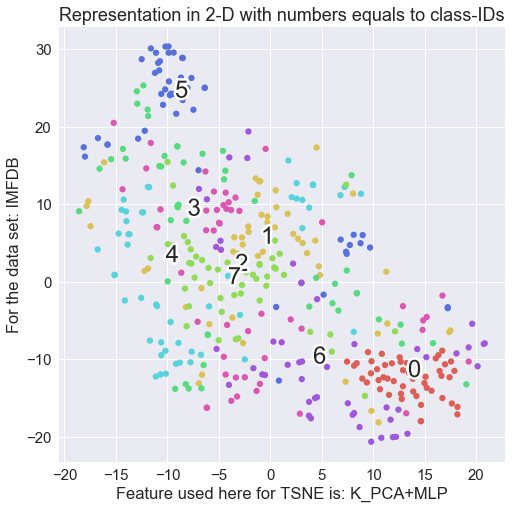

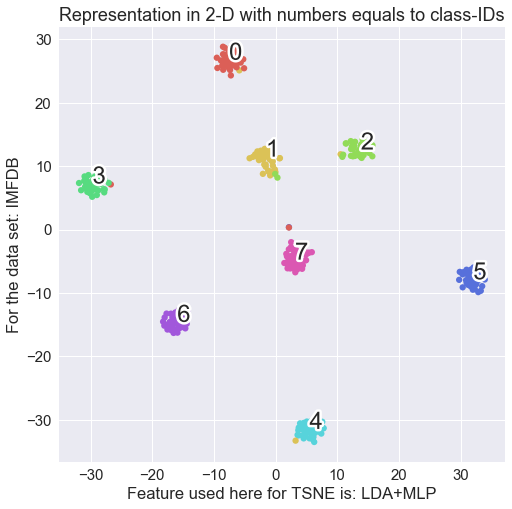

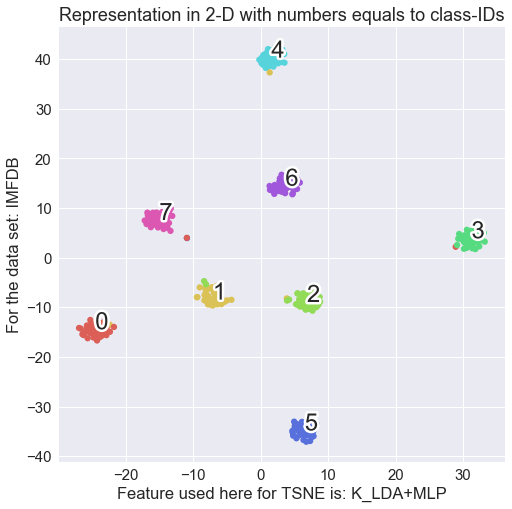

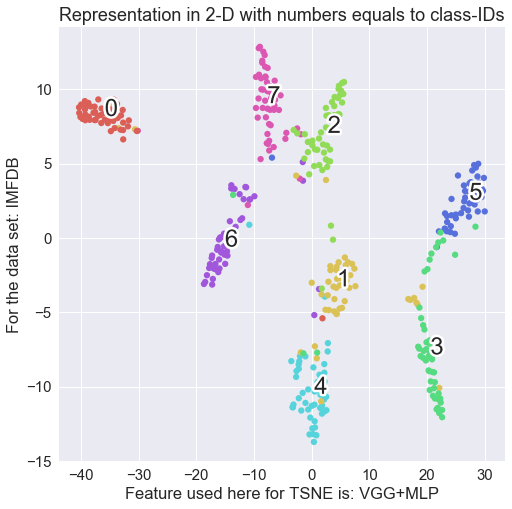

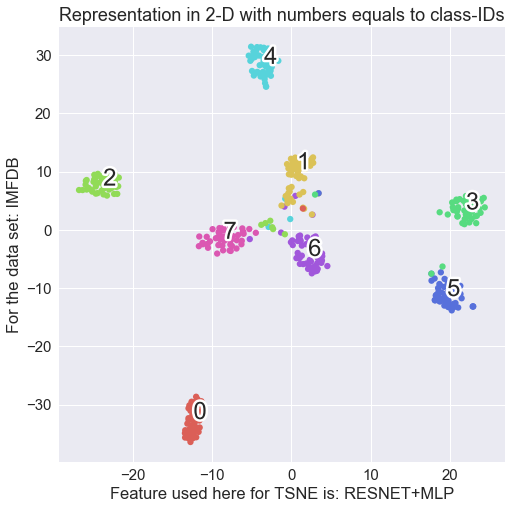

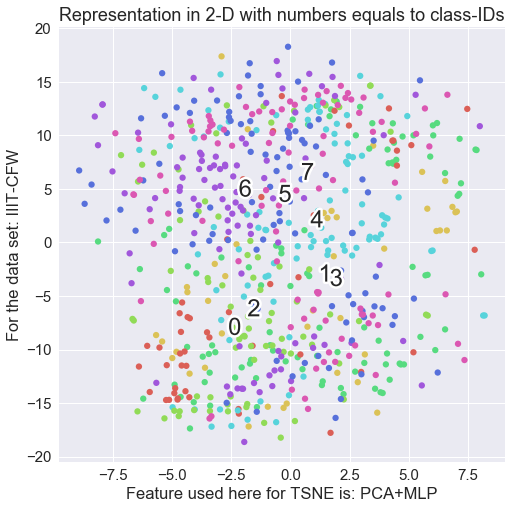

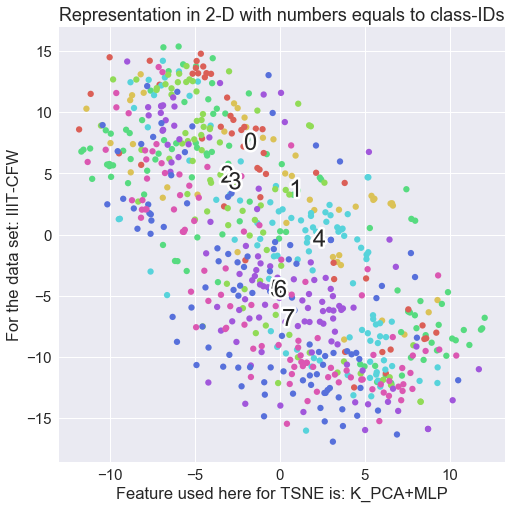

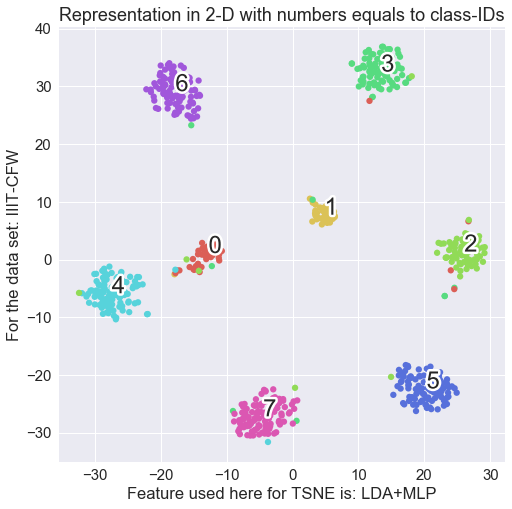

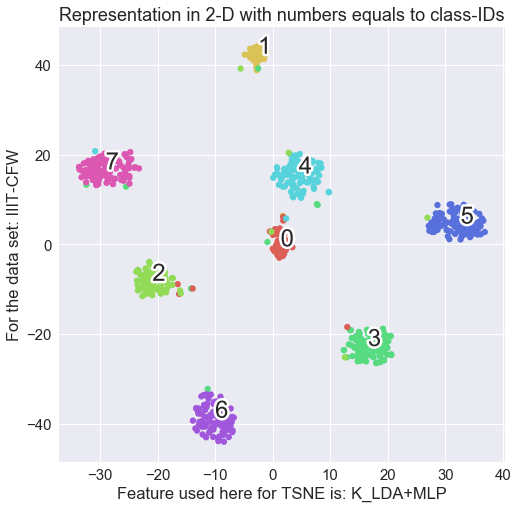

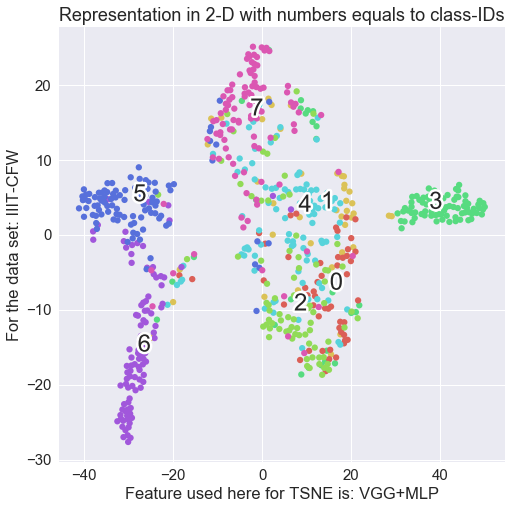

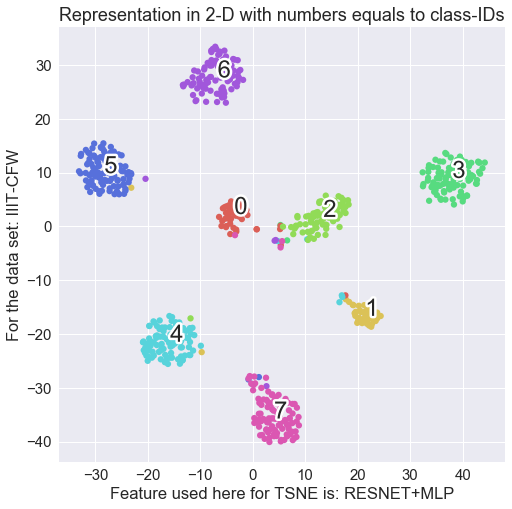

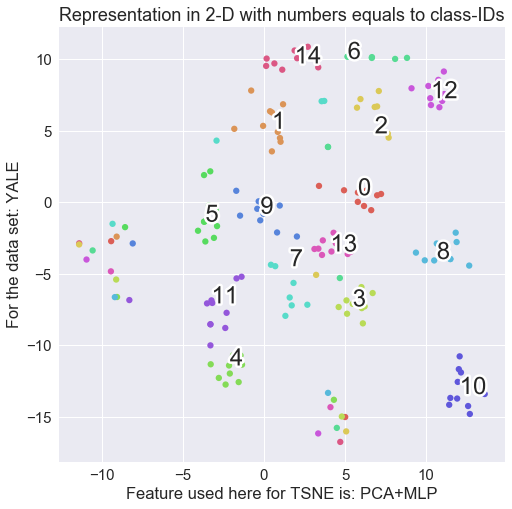

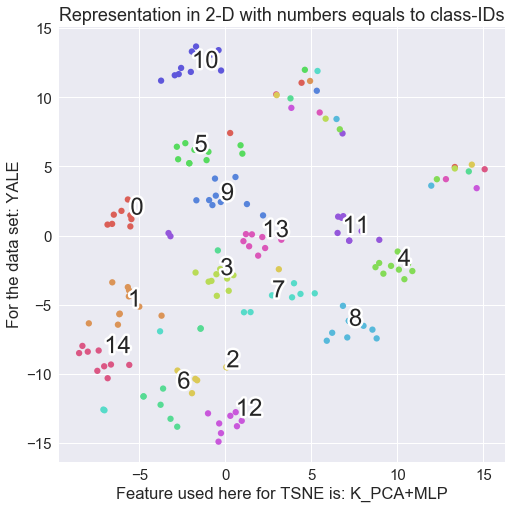

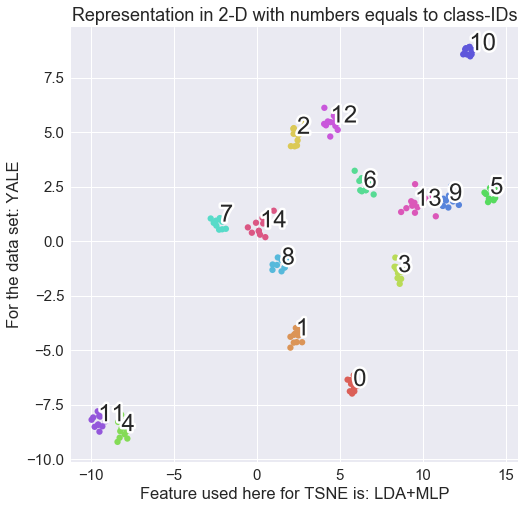

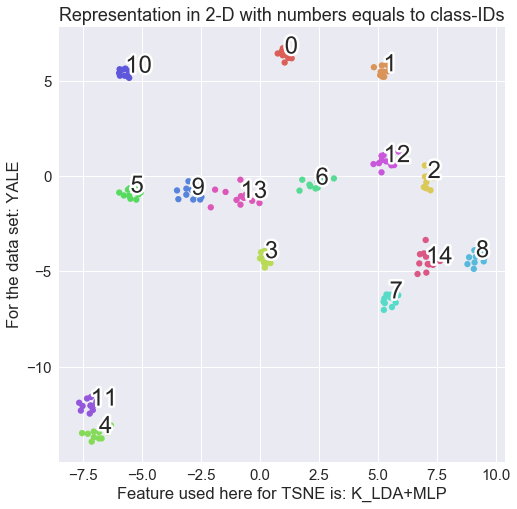

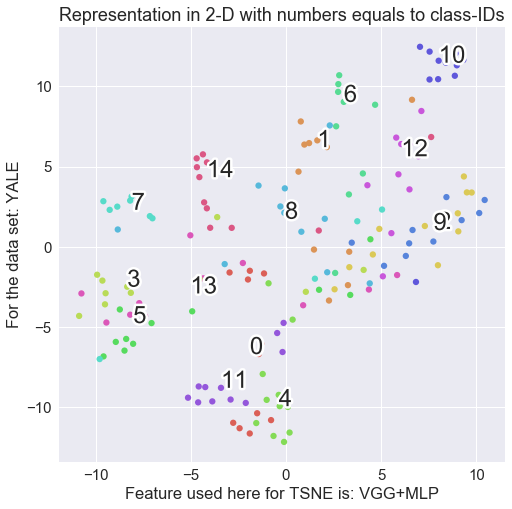

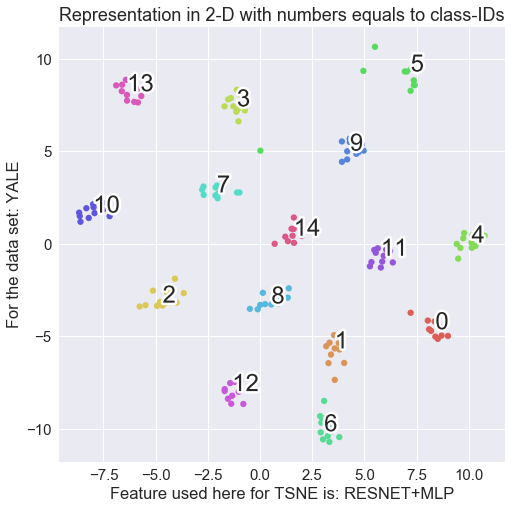

In [34]:
# Compute TSNE for different features and create a scatter plot
comp1 = np.array([142,142,7,7,4096,2048])
comp2 = np.array([338,338,7,7,4096,2048])
comp3= np.array([69,69,7,7,4096,2048])
feature_list = ['PCA+MLP','K_PCA+MLP','LDA+MLP','K_LDA+MLP','VGG+MLP','RESNET+MLP']
dat=['IMFDB','IIIT-CFW','YALE']
def sca_tsne(comp,path,feature_list,dat):
    for i in range(6):
        X_n,y=Features_for_TSNE(i+1,comp[i],path)
        X_TSNE = TSNE(n_components=2).fit_transform(X_n)
        fashion_scatter(X_TSNE,y)
        plt.title('Representation in 2-D with numbers equals to class-IDs')  
        plt.xlabel('Feature used here for TSNE is: '+str(feature_list[i]))
        plt.ylabel('For the data set: '+str(dat[path-1]))

sca_tsne(comp1,1,feature_list,dat)
sca_tsne(comp2,2,feature_list,dat)
sca_tsne(comp3,3,feature_list,dat)

Dataset shape: (400, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)
(1237, 32, 32, 3) (1237,)


C:\Users\charan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\charan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


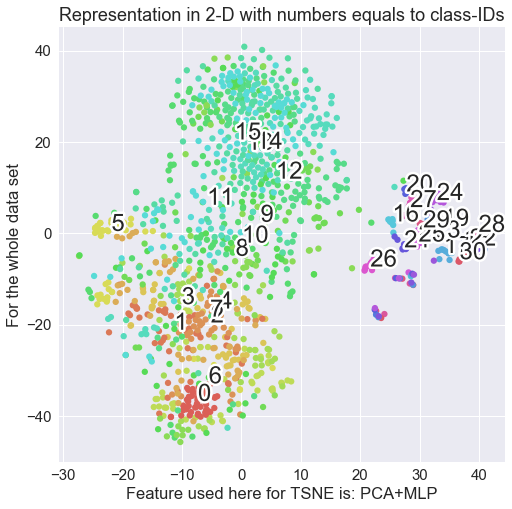

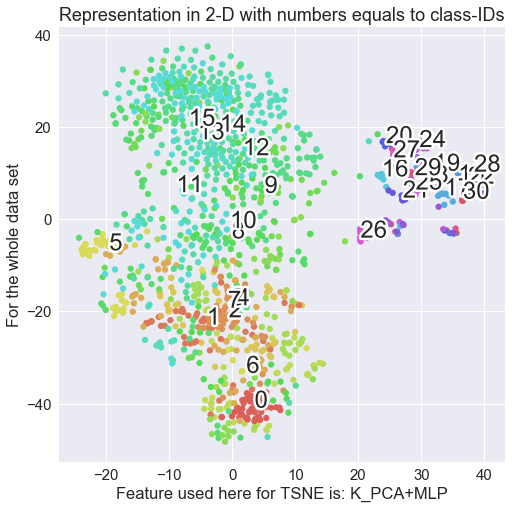

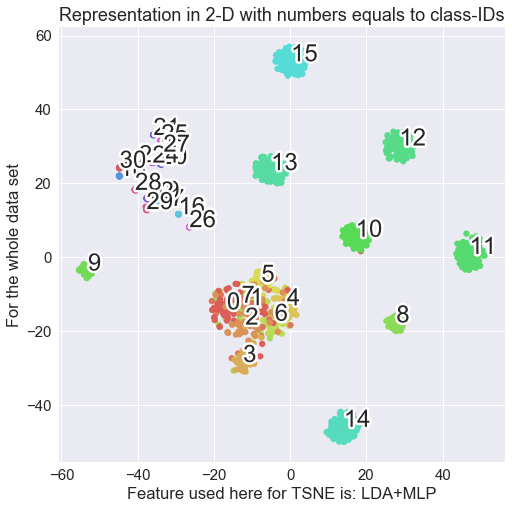

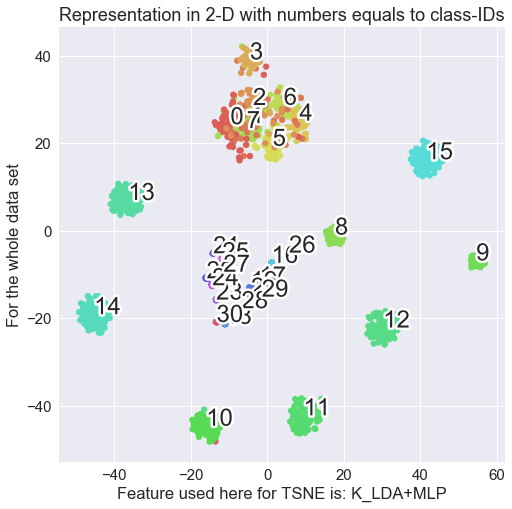

In [35]:
#TSNE Combined data set
#0-7 IMFDB data set labels
#8-15 IIIT-CFW data set labels
#16-30 YALE data set labels

dirpath = './dataset/IMFDB/'
X,y=load_data(dirpath)
dirpath='./dataset/IIIT-CFW/'
X1,y1=load_data(dirpath)
dirpath='./dataset/Yale_face_database/'      
X2,y2=load_data(dirpath)
y1=y1+8
y2=y2+16
y_new=np.concatenate((y,y1,y2))
X_new=np.concatenate((X,X1,X2))
print(X_new.shape,y_new.shape)
comp=np.array([338,338,7,7])
for i in range(4):
        X_n,y= Features_for_COMBINED_DATASET_TSNE(X_new,y_new,i+1,comp[i])
        X_TSNE = TSNE(n_components=2).fit_transform(X_n)
        fashion_scatter(X_TSNE,y)
        plt.title('Representation in 2-D with numbers equals to class-IDs')  
        plt.xlabel('Feature used here for TSNE is: '+str(feature_list[i]))
        plt.ylabel('For the whole data set')

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [36]:
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn import metrics

In [37]:
class FaceVerification():
    def __init__(self,k=7):
#         super.__init__()
        self.nn=k
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def verify(self,X,class_id):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        pred = self.model.predict(X)
        verification_results = (pred == class_id)
        return verification_results
    
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.model = knn(n_neighbors = self.nn)
        self.model.fit(X_train,y_train)
        
    def validate(self,X_validate,y_validate):
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        y_pred = self.model.predict(X_validate)
        acc=metrics.accuracy_score(y_validate, y_pred)
        acc = acc*100
        error = 100 - acc
        precision =  precision_score(y_validate,self.model.predict(X_validate),average = 'macro')
        return error,acc,precision


In [38]:
# Create a train and validation split and show your results 


 For k=  5

IMFDB
Dataset shape: (400, 32, 32, 3)


,Method,Reduced Space,verification error,Accuracy,precision
0,PCA+MLP,142,38.75,61.25,0.699196
1,K_PCA+MLP,142,46.25,53.75,0.665695
2,LDA+MLP,7,1.25,98.75,0.986111
3,K_LDA+MLP,7,0.00,100.00,1.000000
4,VGG+MLP,4096,10.00,90.00,0.887404
5,RESNET+MLP,2048,1.25,98.75,0.988636



CFW
Dataset shape: (672, 32, 32, 3)


,Method,Reduced Space,verification error,Accuracy,precision
0,PCA+MLP,338,75.555556,24.444444,0.342493
1,K_PCA+MLP,338,68.888889,31.111111,0.414912
2,LDA+MLP,7,2.222222,97.777778,0.975429
3,K_LDA+MLP,7,2.222222,97.777778,0.976705
4,VGG+MLP,4096,31.111111,68.888889,0.679880
5,RESNET+MLP,2048,3.703704,96.296296,0.965204



Yale
Dataset shape: (165, 32, 32, 3)


,Method,Reduced Space,verification error,Accuracy,precision
0,PCA+MLP,69,21.212121,78.787879,0.827778
1,K_PCA+MLP,69,15.151515,84.848485,0.829167
2,LDA+MLP,7,3.030303,96.969697,0.977778
3,K_LDA+MLP,7,3.030303,96.969697,0.964286
4,VGG+MLP,4096,48.484848,51.515152,0.513333
5,RESNET+MLP,2048,0.000000,100.000000,1.000000



 For k=  7

IMFDB
Dataset shape: (400, 32, 32, 3)


,Method,Reduced Space,verification error,Accuracy,precision
0,PCA+MLP,142,37.50,62.50,0.706382
1,K_PCA+MLP,142,46.25,53.75,0.627431
2,LDA+MLP,7,3.75,96.25,0.960623
3,K_LDA+MLP,7,2.50,97.50,0.975000
4,VGG+MLP,4096,10.00,90.00,0.897077
5,RESNET+MLP,2048,1.25,98.75,0.987500



CFW
Dataset shape: (672, 32, 32, 3)


,Method,Reduced Space,verification error,Accuracy,precision
0,PCA+MLP,338,72.592593,27.407407,0.359394
1,K_PCA+MLP,338,71.111111,28.888889,0.474290
2,LDA+MLP,7,5.185185,94.814815,0.946839
3,K_LDA+MLP,7,2.962963,97.037037,0.975116
4,VGG+MLP,4096,33.333333,66.666667,0.666595
5,RESNET+MLP,2048,2.962963,97.037037,0.971230



Yale
Dataset shape: (165, 32, 32, 3)


,Method,Reduced Space,verification error,Accuracy,precision
0,PCA+MLP,69,18.181818,81.818182,0.946032
1,K_PCA+MLP,69,15.151515,84.848485,0.928571
2,LDA+MLP,7,0.000000,100.000000,1.000000
3,K_LDA+MLP,7,3.030303,96.969697,0.964286
4,VGG+MLP,4096,45.454545,54.545455,0.493333
5,RESNET+MLP,2048,0.000000,100.000000,1.000000



 For k=  9

IMFDB
Dataset shape: (400, 32, 32, 3)


,Method,Reduced Space,verification error,Accuracy,precision
0,PCA+MLP,142,38.75,61.25,0.701366
1,K_PCA+MLP,142,32.50,67.50,0.768914
2,LDA+MLP,7,2.50,97.50,0.978220
3,K_LDA+MLP,7,3.75,96.25,0.968344
4,VGG+MLP,4096,11.25,88.75,0.892366
5,RESNET+MLP,2048,5.00,95.00,0.965861



CFW
Dataset shape: (672, 32, 32, 3)


,Method,Reduced Space,verification error,Accuracy,precision
0,PCA+MLP,338,67.407407,32.592593,0.546651
1,K_PCA+MLP,338,65.925926,34.074074,0.462162
2,LDA+MLP,7,2.962963,97.037037,0.969345
3,K_LDA+MLP,7,2.962963,97.037037,0.957528
4,VGG+MLP,4096,28.148148,71.851852,0.704398
5,RESNET+MLP,2048,3.703704,96.296296,0.969433



Yale
Dataset shape: (165, 32, 32, 3)


,Method,Reduced Space,verification error,Accuracy,precision
0,PCA+MLP,69,24.242424,75.757576,0.586905
1,K_PCA+MLP,69,18.181818,81.818182,0.717778
2,LDA+MLP,7,3.030303,96.969697,0.977778
3,K_LDA+MLP,7,0.000000,100.000000,1.000000
4,VGG+MLP,4096,51.515152,48.484848,0.644444
5,RESNET+MLP,2048,0.000000,100.000000,1.000000



 For k=  11

IMFDB
Dataset shape: (400, 32, 32, 3)


,Method,Reduced Space,verification error,Accuracy,precision
0,PCA+MLP,142,46.25,53.75,0.584785
1,K_PCA+MLP,142,33.75,66.25,0.797961
2,LDA+MLP,7,1.25,98.75,0.988636
3,K_LDA+MLP,7,0.00,100.00,1.000000
4,VGG+MLP,4096,13.75,86.25,0.858180
5,RESNET+MLP,2048,2.50,97.50,0.977273



CFW
Dataset shape: (672, 32, 32, 3)


,Method,Reduced Space,verification error,Accuracy,precision
0,PCA+MLP,338,66.666667,33.333333,0.652240
1,K_PCA+MLP,338,66.666667,33.333333,0.565490
2,LDA+MLP,7,2.962963,97.037037,0.964286
3,K_LDA+MLP,7,5.925926,94.074074,0.939033
4,VGG+MLP,4096,24.444444,75.555556,0.741405
5,RESNET+MLP,2048,2.222222,97.777778,0.972588



Yale
Dataset shape: (165, 32, 32, 3)


,Method,Reduced Space,verification error,Accuracy,precision
0,PCA+MLP,69,24.242424,75.757576,0.750000
1,K_PCA+MLP,69,33.333333,66.666667,0.678571
2,LDA+MLP,7,0.000000,100.000000,1.000000
3,K_LDA+MLP,7,3.030303,96.969697,0.979167
4,VGG+MLP,4096,57.575758,42.424242,0.421429
5,RESNET+MLP,2048,3.030303,96.969697,0.928571



 For k=  13

IMFDB
Dataset shape: (400, 32, 32, 3)


,Method,Reduced Space,verification error,Accuracy,precision
0,PCA+MLP,142,40.00,60.00,0.661677
1,K_PCA+MLP,142,42.50,57.50,0.684749
2,LDA+MLP,7,2.50,97.50,0.979167
3,K_LDA+MLP,7,1.25,98.75,0.986111
4,VGG+MLP,4096,2.50,97.50,0.982143
5,RESNET+MLP,2048,5.00,95.00,0.952020



CFW
Dataset shape: (672, 32, 32, 3)


,Method,Reduced Space,verification error,Accuracy,precision
0,PCA+MLP,338,70.370370,29.629630,0.509921
1,K_PCA+MLP,338,62.962963,37.037037,0.633002
2,LDA+MLP,7,1.481481,98.518519,0.986695
3,K_LDA+MLP,7,5.185185,94.814815,0.947192
4,VGG+MLP,4096,36.296296,63.703704,0.636202
5,RESNET+MLP,2048,2.222222,97.777778,0.979861



Yale
Dataset shape: (165, 32, 32, 3)


,Method,Reduced Space,verification error,Accuracy,precision
0,PCA+MLP,69,27.272727,72.727273,0.717778
1,K_PCA+MLP,69,24.242424,75.757576,0.766667
2,LDA+MLP,7,15.151515,84.848485,0.945055
3,K_LDA+MLP,7,33.333333,66.666667,0.832200
4,VGG+MLP,4096,51.515152,48.484848,0.503846
5,RESNET+MLP,2048,3.030303,96.969697,0.984615



 For k=  15

IMFDB
Dataset shape: (400, 32, 32, 3)


,Method,Reduced Space,verification error,Accuracy,precision
0,PCA+MLP,142,51.25,48.75,0.708135
1,K_PCA+MLP,142,42.50,57.50,0.616196
2,LDA+MLP,7,1.25,98.75,0.989583
3,K_LDA+MLP,7,1.25,98.75,0.991667
4,VGG+MLP,4096,10.00,90.00,0.895139
5,RESNET+MLP,2048,3.75,96.25,0.960871



CFW
Dataset shape: (672, 32, 32, 3)


,Method,Reduced Space,verification error,Accuracy,precision
0,PCA+MLP,338,68.888889,31.111111,0.305490
1,K_PCA+MLP,338,66.666667,33.333333,0.568897
2,LDA+MLP,7,2.962963,97.037037,0.974404
3,K_LDA+MLP,7,4.444444,95.555556,0.965541
4,VGG+MLP,4096,26.666667,73.333333,0.736245
5,RESNET+MLP,2048,4.444444,95.555556,0.963307



Yale
Dataset shape: (165, 32, 32, 3)


,Method,Reduced Space,verification error,Accuracy,precision
0,PCA+MLP,69,42.424242,57.575758,0.532823
1,K_PCA+MLP,69,42.424242,57.575758,0.640000
2,LDA+MLP,7,0.000000,100.000000,1.000000
3,K_LDA+MLP,7,6.060606,93.939394,0.946429
4,VGG+MLP,4096,48.484848,51.515152,0.522222
5,RESNET+MLP,2048,0.000000,100.000000,1.000000



 For k=  17

IMFDB
Dataset shape: (400, 32, 32, 3)


,Method,Reduced Space,verification error,Accuracy,precision
0,PCA+MLP,142,46.25,53.75,0.606250
1,K_PCA+MLP,142,36.25,63.75,0.704657
2,LDA+MLP,7,0.00,100.00,1.000000
3,K_LDA+MLP,7,0.00,100.00,1.000000
4,VGG+MLP,4096,8.75,91.25,0.913346
5,RESNET+MLP,2048,0.00,100.00,1.000000



CFW
Dataset shape: (672, 32, 32, 3)


,Method,Reduced Space,verification error,Accuracy,precision
0,PCA+MLP,338,68.148148,31.851852,0.633768
1,K_PCA+MLP,338,71.111111,28.888889,0.620703
2,LDA+MLP,7,2.222222,97.777778,0.984788
3,K_LDA+MLP,7,3.703704,96.296296,0.963942
4,VGG+MLP,4096,28.888889,71.111111,0.556391
5,RESNET+MLP,2048,0.740741,99.259259,0.989583



Yale
Dataset shape: (165, 32, 32, 3)


,Method,Reduced Space,verification error,Accuracy,precision
0,PCA+MLP,69,57.575758,42.424242,0.519048
1,K_PCA+MLP,69,39.393939,60.606061,0.550000
2,LDA+MLP,7,21.212121,78.787879,0.845238
3,K_LDA+MLP,7,36.363636,63.636364,0.694872
4,VGG+MLP,4096,54.545455,45.454545,0.546667
5,RESNET+MLP,2048,3.030303,96.969697,0.964286



 For k=  19

IMFDB
Dataset shape: (400, 32, 32, 3)


,Method,Reduced Space,verification error,Accuracy,precision
0,PCA+MLP,142,45.00,55.00,0.669213
1,K_PCA+MLP,142,43.75,56.25,0.720788
2,LDA+MLP,7,1.25,98.75,0.989583
3,K_LDA+MLP,7,3.75,96.25,0.958279
4,VGG+MLP,4096,12.50,87.50,0.878647
5,RESNET+MLP,2048,3.75,96.25,0.957051



CFW
Dataset shape: (672, 32, 32, 3)


,Method,Reduced Space,verification error,Accuracy,precision
0,PCA+MLP,338,55.555556,44.444444,0.610699
1,K_PCA+MLP,338,71.111111,28.888889,0.437354
2,LDA+MLP,7,2.222222,97.777778,0.980035
3,K_LDA+MLP,7,2.962963,97.037037,0.955754
4,VGG+MLP,4096,31.111111,68.888889,0.693784
5,RESNET+MLP,2048,2.962963,97.037037,0.965117



Yale
Dataset shape: (165, 32, 32, 3)


,Method,Reduced Space,verification error,Accuracy,precision
0,PCA+MLP,69,45.454545,54.545455,0.565556
1,K_PCA+MLP,69,51.515152,48.484848,0.559524
2,LDA+MLP,7,24.242424,75.757576,0.811111
3,K_LDA+MLP,7,48.484848,51.515152,0.527778
4,VGG+MLP,4096,75.757576,24.242424,0.297619
5,RESNET+MLP,2048,0.000000,100.000000,1.000000


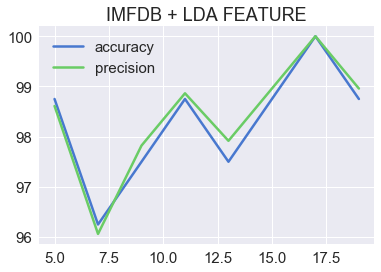

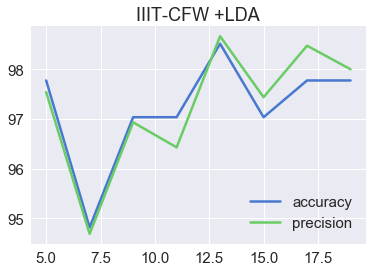

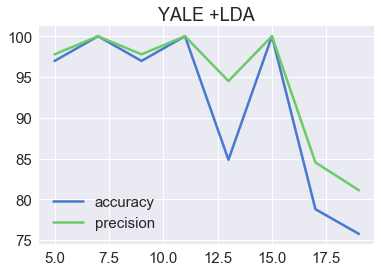

In [56]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score
import warnings
comp1 = np.array([142,142,7,7,4096,2048])
comp2 = np.array([338,338,7,7,4096,2048])
comp3= np.array([69,69,7,7,4096,2048])
type_array = np.array([1,2,3,4,5,6])
feature_list = ['PCA+MLP','K_PCA+MLP','LDA+MLP','K_LDA+MLP','VGG+MLP','RESNET+MLP']
def knn_faces_table(path,k):
    global comp1,comp2,comp3,type_array,feature_list
    err = np.zeros(6)
    acc = np.zeros(6)
    pre = np.zeros(6)
    rec = np.zeros(6)
    if path==1:
        X,y = load_data('./dataset/IMFDB/')
        comp=comp1
        out=8
    elif path==2:
        X,y = load_data('./dataset/IIIT-CFW/')
        comp=comp2
        out=8
    elif path==3:
        X,y = load_data('./dataset/Yale_face_database')
        comp=comp3
        out=15
    for i in range(6):
        X_train,X_test,y_train,y_test = division_train_test(X,y,feature=type_array[i],comp=comp[i],path=path)
        clf =  FaceVerification(k=k)
        clf.train(X_train,y_train)
        err[i],acc[i],pre[i]  = clf.validate(X_test,y_test)
    best_model = np.argmax(acc)
    df = pd.DataFrame({
        'Method' : pd.Categorical(feature_list),
        'Reduced Space':comp,
        'verification error':err ,
        'Accuracy':acc ,
        'precision':pre })
    return df,best_model,acc,pre*100
# Print the table. (You can use Pandas)
best_models = np.zeros(3)
acc1=[]
pre1=[]
acc2=[]
pre2=[]
acc3=[]
pre3=[]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(5,20,2):
        print("\n For k= ",i)
        print("\nIMFDB")
        df1,best_models[0],acc,pre = knn_faces_table(path=1,k=i)
        display(df1)
        acc1.append(acc[2])
        pre1.append(pre[2])

        print("\nCFW")
        df2,best_models[1],acc,pre = knn_faces_table(path=2,k=i)
        display(df2)
        acc2.append(acc[2])
        pre2.append(pre[2])
        print("\nYale")
        df3,best_models[2],acc,pre = knn_faces_table(path=3,k=i) 
        display(df3)
        acc3.append(acc[2])
        pre3.append(pre[2])
plt.title("IMFDB + LDA FEATURE")
xx=list(range(5,20,2))
plt.plot(xx,acc1,label='accuracy')
plt.plot(xx,pre1,label='precision')
plt.legend()
plt.show()
plt.title("IIIT-CFW +LDA")
plt.plot(xx,acc2,label='accuracy')
plt.plot(xx,pre2,label='precision')
plt.legend()
plt.show()
plt.title("YALE +LDA")
plt.plot(xx,acc3,label='accuracy')
plt.plot(xx,pre3,label='precision')
plt.legend()
plt.show()

### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [40]:
# Load data
#Cartoon Vs Real Images
dirpath = './dataset/IMFDB/'
X,y=load_data(dirpath)
dirpath='./dataset/IIIT-CFW/'
X1,y1=load_data(dirpath)
dirpath='./dataset/Yale_face_database/'      
X2,y2=load_data(dirpath)
y1=y1-y1   #cartoon Label=0
y2=y2-y2+1   #Real Label=1
y=y-y+1    #Real   Label=1
y_new=np.concatenate((y,y1,y2))
X_new=np.concatenate((X,X1,X2))
print(X_new.shape,y_new.shape)

Dataset shape: (400, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)
(1237, 32, 32, 3) (1237,)


In [41]:
# Define your features
def Features_for_CartoonVsReal(X,y,feature,comp):
    N_n,H_n,W_n = X.shape[0:3]
    C_n = 1 if opt['is_grayscale'] else X.shape[3]
    X = X.reshape((N_n,H_n*W_n*C_n))
    global pca_CR
    if(feature==1):       
        pca_CR = PCA(n_components=comp)
        X_4D = pca_CR.fit_transform(X)
    if(feature==2):
        kpca = KernelPCA(n_components=comp,kernel='rbf',degree=3)
        X_4D = kpca.fit_transform(X)
    if(feature==4):
        kernel="rbf"
        degree=3
        if kernel == "poly":
            X_transformed = X**degree
        elif kernel == "rbf":
            var = np.var(X)
            X_transformed= np.exp(-X/(2*var))
        elif kernel == "sigmoid":
            X_transformed = np.tanh(X)
        else: 
            raise NotImplementedError("Kernel {} Not defined".format(kernel))
        klda = LDA(n_components=comp)
        X_4D = klda.fit_transform(X,y)
    if(feature==3):
        lda = LDA(n_components=comp)
        X_4D = lda.fit_transform(X,y)
    if(feature==5):
        kernel="sigmoid"
        degree=3
        if kernel == "poly":
            X_transformed = X**degree
        elif kernel == "rbf":
            var = np.var(X)
            X_transformed= np.exp(-X/(2*var))
        elif kernel == "sigmoid":
            X_transformed = np.tanh(X)
        else: 
            raise NotImplementedError("Kernel {} Not defined".format(kernel))
        klda = LDA(n_components=comp)
        X_4D = klda.fit_transform(X,y)
    if(feature==6):
        kpca = KernelPCA(n_components=comp,kernel='poly',degree=3)
        X_4D = kpca.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_4D, y, test_size=0.2)
    return X_train, X_test, y_train, y_test,pca_CR

In [42]:
# Create your classifier
class Classifier_CR():
    def __init__(self,start =1):
         self.start = start    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
        """
        prediction=self.model.predict(X)
        class_labels_pred = np.argmax(prediction, axis=1)
        prediction=class_labels_pred
        return prediction
        
    def confusion_matrix(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        cm = confusion_matrix(pred, y)
        return cm
    def train(self,X_train,y_train,comp,out):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.model = Sequential()
        self.model.add(Dense(200, input_dim=comp,activation='relu'))
        self.model.add(Dense(200, activation='relu'))
        self.model.add(Dense(out, activation='softmax'))
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        encoder = LabelEncoder()
        encoder.fit(y_train)
        encoded_Y = encoder.transform(y_train)
        y_tr=to_categorical(encoded_Y)        
        self.model.fit(X_train, y_tr,epochs=50,verbose=0)

    def validate(self,X_validate,y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        y_pred=self.model.predict(X_validate)
        class_labels_pred = np.argmax(y_pred, axis=1)
        val_acc = accuracy_score(y_validate,class_labels_pred,normalize = True)
        precision = precision_score(y_validate,class_labels_pred,average = 'macro')
        recall = recall_score(y_validate,class_labels_pred,average = 'macro')
        f1 = f1_score(y_validate,class_labels_pred,average = 'macro')
        return val_acc,precision,recall,f1
    def KCV(self,X,dummy_y):
        estimator = KerasClassifier(build_fn=self.model, epochs=50, batch_size=5, verbose=0)
        kfold = KFold(n_splits=10, shuffle=True)
        results = cross_val_score(estimator, X, dummy_y, cv=kfold)
        print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
        return results.mean()*100,results.std()*100

In [43]:
#Validating classifier
import warnings
comp_new = np.array([40,40,1,1,1,40])
feature_list = ['PCA+MLP','K_PCA(RBF)+MLP','LDA+MLP','K_LDA(RBF)+MLP','K_LDA_(SIGMOID)+MLP','K_PCA(POLY)+MLP']
def faces_table_CR(X,y):
    global comp_new
    acc = np.zeros(6)
    f1 = np.zeros(6)
    pre = np.zeros(6)
    rec = np.zeros(6)
    out=2
    for i in range(6):
        X_train,X_test,y_train,y_test,_ = Features_for_CartoonVsReal(X,y,feature=i+1,comp=comp_new[i])
        print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
        clf = Classifier_CR(start=1)
        clf.train(X_train,y_train,comp_new[i],out=2)
        pred = clf.classify(X_test)
        acc[i],pre[i],rec[i],f1[i] = clf.validate(X_test,y_test)
    
    acc = 100*acc
    clf_err = 100 - acc
    df = pd.DataFrame({
        'Method' : pd.Categorical(feature_list),
        'Reduced Space':comp_new,
        'Classification error':clf_err ,
        'Accuracy':acc ,
        'f1-score':f1,
        'precision':pre,
        'recall':rec })
    return df
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print("\nCartoon Vs Real Images Data Set")
    df1 = faces_table_CR(X_new,y_new)
    display(df1)


Cartoon Vs Real Images Data Set
(989, 40) (248, 40) (989,) (248,)
(989, 40) (248, 40) (989,) (248,)
(989, 1) (248, 1) (989,) (248,)
(989, 1) (248, 1) (989,) (248,)
(989, 1) (248, 1) (989,) (248,)
(989, 40) (248, 40) (989,) (248,)


,Method,Reduced Space,Classification error,Accuracy,f1-score,precision,recall
0,PCA+MLP,40,1.612903,98.387097,0.983786,0.983786,0.983786
1,K_PCA(RBF)+MLP,40,4.032258,95.967742,0.958708,0.955118,0.964437
2,LDA+MLP,1,0.000000,100.000000,1.000000,1.000000,1.000000
3,K_LDA(RBF)+MLP,1,0.000000,100.000000,1.000000,1.000000,1.000000
4,K_LDA_(SIGMOID)+MLP,1,0.000000,100.000000,1.000000,1.000000,1.000000
5,K_PCA(POLY)+MLP,40,3.225806,96.774194,0.967708,0.967708,0.967708


C:\Users\charan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\charan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\charan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


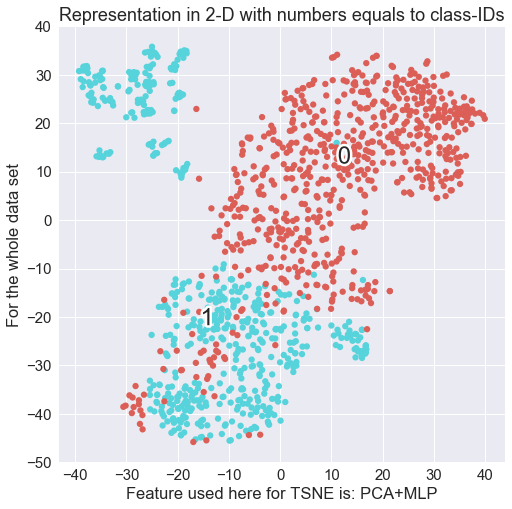

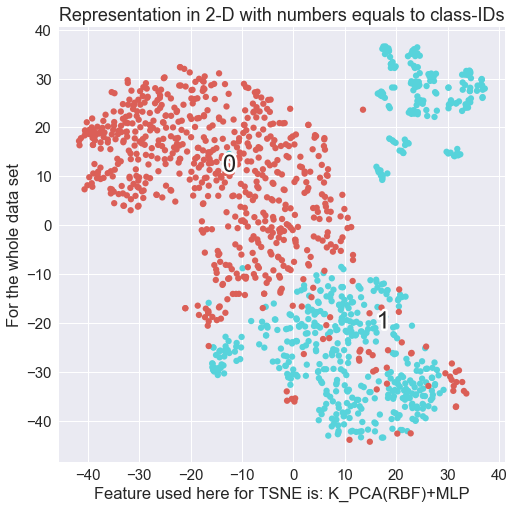

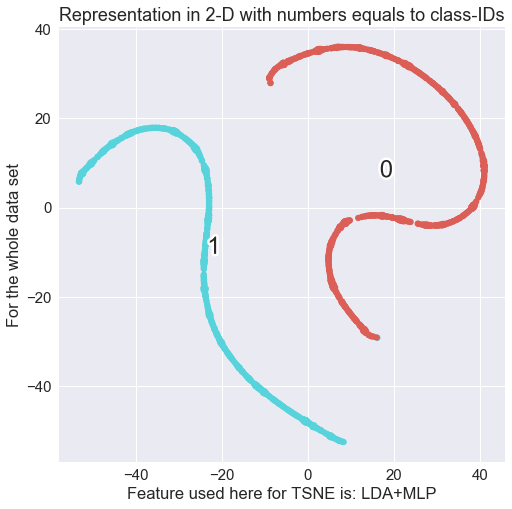

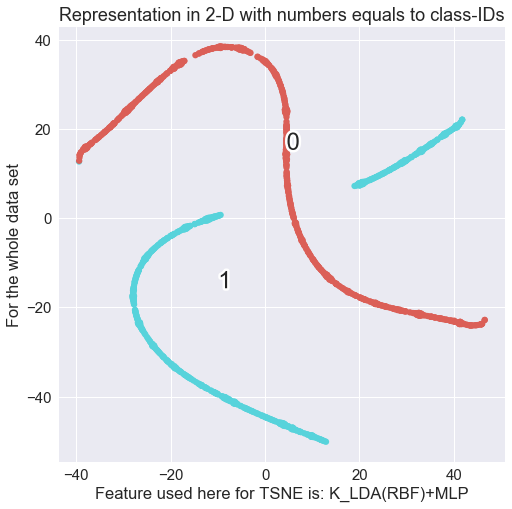

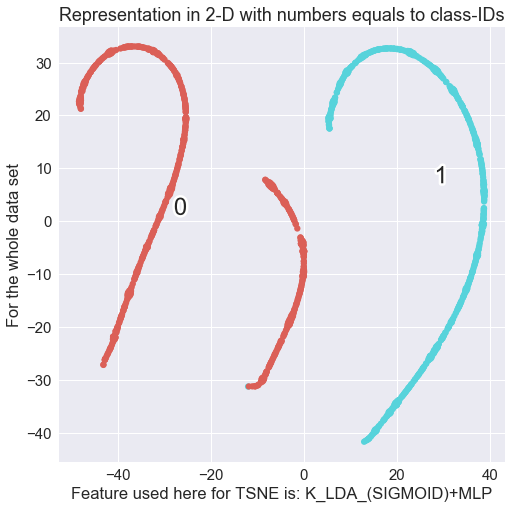

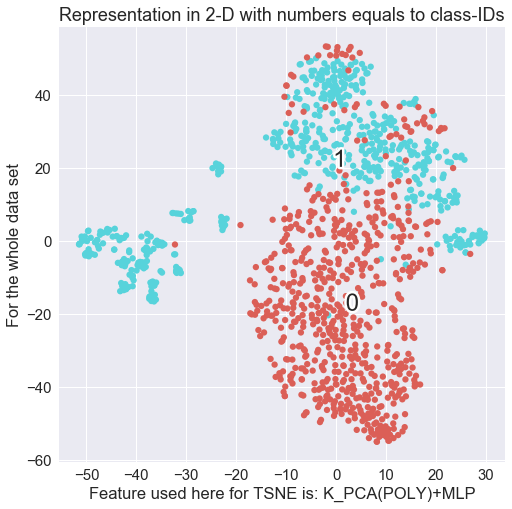

In [44]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.
def TSNE_CartoonVsReal(X,y,feature,comp):
    N_n,H_n,W_n = X.shape[0:3]
    C_n = 1 if opt['is_grayscale'] else X.shape[3]
    X = X.reshape((N_n,H_n*W_n*C_n))
    if(feature==1):       
        pca = PCA(n_components=comp)
        X_4D = pca.fit_transform(X)
    if(feature==2):
        kpca = KernelPCA(n_components=comp,kernel='rbf',degree=3)
        X_4D = kpca.fit_transform(X)
    if(feature==4):
        kernel="rbf"
        degree=3
        if kernel == "poly":
            X_transformed = X**degree
        elif kernel == "rbf":
            var = np.var(X)
            X_transformed= np.exp(-X/(2*var))
        elif kernel == "sigmoid":
            X_transformed = np.tanh(X)
        else: 
            raise NotImplementedError("Kernel {} Not defined".format(kernel))
        klda = LDA(n_components=comp)
        X_4D = klda.fit_transform(X,y)
    if(feature==3):
        lda = LDA(n_components=comp)
        X_4D = lda.fit_transform(X,y)
    if(feature==5):
        kernel="sigmoid"
        degree=3
        if kernel == "poly":
            X_transformed = X**degree
        elif kernel == "rbf":
            var = np.var(X)
            X_transformed= np.exp(-X/(2*var))
        elif kernel == "sigmoid":
            X_transformed = np.tanh(X)
        else: 
            raise NotImplementedError("Kernel {} Not defined".format(kernel))
        klda = LDA(n_components=comp)
        X_4D = klda.fit_transform(X,y)
    if(feature==6):
        kpca = KernelPCA(n_components=comp,kernel='poly',degree=3)
        X_4D = kpca.fit_transform(X)
    return X_4D,y

for i in range(6):
        X_n,y= TSNE_CartoonVsReal(X_new,y_new,i+1,comp_new[i])
        X_TSNE = TSNE(n_components=2).fit_transform(X_n)
        fashion_scatter(X_TSNE,y)
        plt.title('Representation in 2-D with numbers equals to class-IDs')  
        plt.xlabel('Feature used here for TSNE is: '+str(feature_list[i]))
        plt.ylabel('For the whole data set')

In [47]:
# Show quantitative results such as examples of correct prediction and wrong prediction
import random
# X_train,X_test,y_train,y_test,p_c_a = Features_for_CartoonVsReal(X_new,y_new,feature=1,comp=comp_new[0])
N_n,H_n,W_n = X_new.shape[0:3]
C_n = 1 if opt['is_grayscale'] else X_new.shape[3]
X_ne = X_new.reshape((N_n,H_n*W_n*C_n))
X_train, X_test, y_train, y_test = train_test_split(X_ne, y_new, test_size=0.2)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
clf = Classifier_CR(start=1)
clf.train(X_train,y_train,3072,out=2)
pred = clf.classify(X_test)
# print(len(pred))
index=[]
index1=[]
for i in range(len(pred)):
    if pred[i]!=y_test[i]:
#         print(pred[i],y_test[i])
        index.append([i,y_test[i],pred[i]])
    else:
        index1.append([i,y_test[i],pred[i]])
# print(index)
index=np.array(index)
index1 = random.sample( index1, len(index))
index1=np.array(index1)
# print(index)

(989, 3072) (248, 3072) (989,) (248,)


In [48]:
# X_te=p_c_a.inverse_transform(X_test)
X_ll=X_test.reshape((248,32,32,3))

Wrongly Classified/Wrong Prediction by MLP classifer
predicted [1 0 1 1 1 0 0 1 0 1]
Actual [0 1 0 0 0 1 1 0 1 0]
0 = cartoon
1 = Real


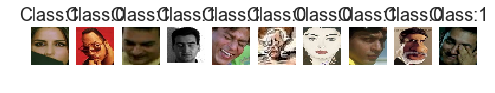

Correctly Classified/Correct Prediction by MLP classifer
[0 0 0 0 1 1 0 0 1 0]


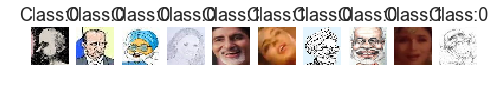

In [49]:
print("Wrongly Classified/Wrong Prediction by MLP classifer")
print("predicted",index[:,1])
print("Actual",index[:,2])
print("0 = cartoon")
print("1 = Real")
disply_images(X_ll[index[:,0]],y_test[index[:,0]], row=1,col=len(index))
print("Correctly Classified/Correct Prediction by MLP classifer")
print(index1[0:len(index),1])
disply_images(X_ll[index1[0:len(index),0]],y_test[index1[0:len(index),0]], row=1,col=len(index))